In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
#!pip install tensorflow-gpu==2.0.0

In [23]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fid = drive.ListFile({'q':"title='cell_images.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('cell_images.zip')

In [29]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [32]:
!unzip cell_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_222.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_87.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_91.png  
 extracting: cell_images/Uninfected/C236ThinF_IMG_20151127_1

In [0]:
PATH = '/content/cell_images'

In [33]:
import os
os.listdir(PATH)

['Uninfected', 'Parasitized']

In [0]:
IMAGE_SIZE = [224, 224]

In [0]:
script_dir = os.path.dirname(".")
training_set_path = os.path.join(script_dir, 'cell_images/')
test_set_path = os.path.join(script_dir, 'cell_images/')

In [36]:
training_set_path

'cell_images/'

In [37]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80142336/80134624 [==============================] - 3s 0us/step


In [0]:
for layer in vgg.layers:
  layer.trainable = False

In [0]:
folders = os.listdir("cell_images/")

In [40]:
folders

['Uninfected', 'Parasitized']

In [0]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [43]:
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [0]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                           validation_split=0.33)

In [46]:
training_set = train_datagen.flow_from_directory(training_set_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 subset="training",
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(test_set_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            subset="validation",
                                            class_mode = 'categorical')

Found 27558 images belonging to 2 classes.
Found 9094 images belonging to 2 classes.


In [47]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/5
862/862 [==============================] - 517s 599ms/step - loss: 0.3670 - accuracy: 0.8442 - val_loss: 0.0850 - val_accuracy: 0.9070
Epoch 2/5
862/862 [==============================] - 507s 589ms/step - loss: 0.2862 - accuracy: 0.8895 - val_loss: 0.6288 - val_accuracy: 0.8672
Epoch 3/5
862/862 [==============================] - 508s 590ms/step - loss: 0.2730 - accuracy: 0.8981 - val_loss: 0.3025 - val_accuracy: 0.8809
Epoch 4/5
862/862 [==============================] - 505s 586ms/step - loss: 0.2551 - accuracy: 0.9061 - val_loss: 1.0771 - val_accuracy: 0.9014
Epoch 5/5
862/862 [==============================] - 506s 587ms/step - loss: 0.2528 - accuracy: 0.9080 - val_loss: 0.0136 - val_accuracy: 0.8981


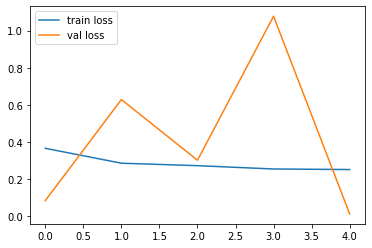

<Figure size 432x288 with 0 Axes>

In [48]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

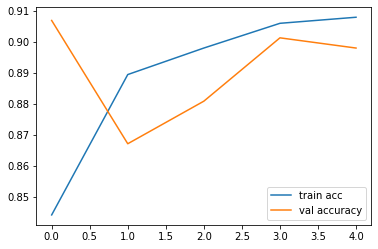

<Figure size 432x288 with 0 Axes>

In [52]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [0]:
model.save('malaria_model.h5')

In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [55]:
!ls /content/gdrive/My Drive

ls: cannot access '/content/gdrive/My': No such file or directory
ls: cannot access 'Drive': No such file or directory
